# 01_Data_Exploratives
Data Exploratives from local Database to get to know more informations about the data

## Contents
* Import Packages and functions
* setting variables
* overview data tables
* overview timelines
  * all data
  * missing days
* pandas profiling

## Import Packages and Functions

In [3]:
import sys
import os

import yaml
import pandas as pd
import pandas_profiling as pd_profil
from sqlalchemy import create_engine

from functions.utils import get_folder

pd.set_option('display.float_format', '{:.2f}'.format)

## Setting Variables
* database connections
* date ranges
* coordinates for analyzing
* ... ?

In [4]:
curr_folder = get_folder()
parent_fold = curr_folder.parent
with open(parent_fold / "connections.yml", encoding='utf-8') as file:
    db_config = yaml.safe_load(file)
    
engine = create_engine(f'postgresql+psycopg2://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["db"]}')

begin_date = ""
end_date = ""

## Overview data tables
* get relevant tables and the number of rows in it
* min max date ranges in table
* number of data points per day

In [5]:
sqlstring = """
SELECT DISTINCT table_schema, table_name
--, column_name, data_type 
FROM INFORMATION_SCHEMA.COLUMNS
WHERE table_schema = 'public'
"""

df = pd.read_sql(sqlstring,con=engine)
df.head()

,table_schema,table_name
0,public,tbl_position
1,public,tbl_staticnew
2,public,tbl_positionnew
3,public,tbl_static


In [13]:
sqlstring = """
SELECT DISTINCT table_name, column_name, data_type 
FROM INFORMATION_SCHEMA.COLUMNS
WHERE table_name IN ('tbl_positionnew','tbl_staticnew','tbl_position','tbl_static')
"""

df = pd.read_sql(sqlstring,con=engine)
print('\033[1m'+ "Fields in the Old Tables: " + '\033[0m')
print('Positional Data: \n', df[df.table_name == 'tbl_position'])
print('Static Data Data: \n', df[df.table_name == 'tbl_static'])

print('\033[1m'+ "Fields in the New Tables: " + '\033[0m')
print('Positional Data: \n', df[df.table_name == 'tbl_positionnew'])
print('Static Data Data: \n', df[df.table_name == 'tbl_staticnew'])



Fields in the Old Tables: 
Positional Data: 
       table_name         column_name data_type
0   tbl_position            aisclass      text
1   tbl_position            altitude      text
2   tbl_position    courseoverground      real
3   tbl_position            latitude      real
4   tbl_position           longitude      real
5   tbl_position         messagetype   integer
6   tbl_position                mmsi   integer
7   tbl_position             msgtime      text
8   tbl_position  navigationalstatus   integer
9   tbl_position          rateofturn   integer
10  tbl_position     speedoverground      real
11  tbl_position         trueheading   integer
12  tbl_position                type      text
Static Data Data: 
     table_name               column_name data_type
26  tbl_static                  callsign      text
27  tbl_static               destination      text
28  tbl_static                dimensiona   integer
29  tbl_static                dimensionb   integer
30  tbl_static       

In [20]:
sqlstring = """
SELECT count(*) AS position_count
FROM tbl_position
"""
df = pd.read_sql(sqlstring,con=engine)
sqlstring = """
SELECT count(*) AS static_count, min(CAST(msgtime AS DATE)) as min_old_date,max(CAST(msgtime AS DATE)) AS max_old_date
FROM tbl_static
"""
df2 = pd.read_sql(sqlstring,con=engine)
sqlstring = """
SELECT count(*) AS positionnew_count
FROM tbl_positionnew
"""
df3 = pd.read_sql(sqlstring,con=engine)
sqlstring = """
SELECT count(*) AS staticnew_count, min(CAST(msgtime AS DATE)) as min_new_date,max(CAST(msgtime AS DATE)) AS max_new_date
FROM tbl_staticnew
"""
df4 = pd.read_sql(sqlstring,con=engine)

pd.concat([df,df2,df3,df4],axis=1)

,position_count,static_count,min_old_date,max_old_date,positionnew_count,staticnew_count,min_new_date,max_new_date
0,31798072,7422634,2022-02-27,2022-04-06,19380822,14263263,2022-04-07,2022-06-16


* In den "Alt" Daten sind über etwas mehr als einen Monat hinweg die Bewegungsdaten in Original gesichert worden.
* In den "Neuen" Daten wurden die Daten auf 10 Minuten Intervalle aggregiert. Das resultierte bei den Positionsdaten zu einer deutlich verringerten Anzahl an Datensätzen für den Zeitraum.

<AxesSubplot:>

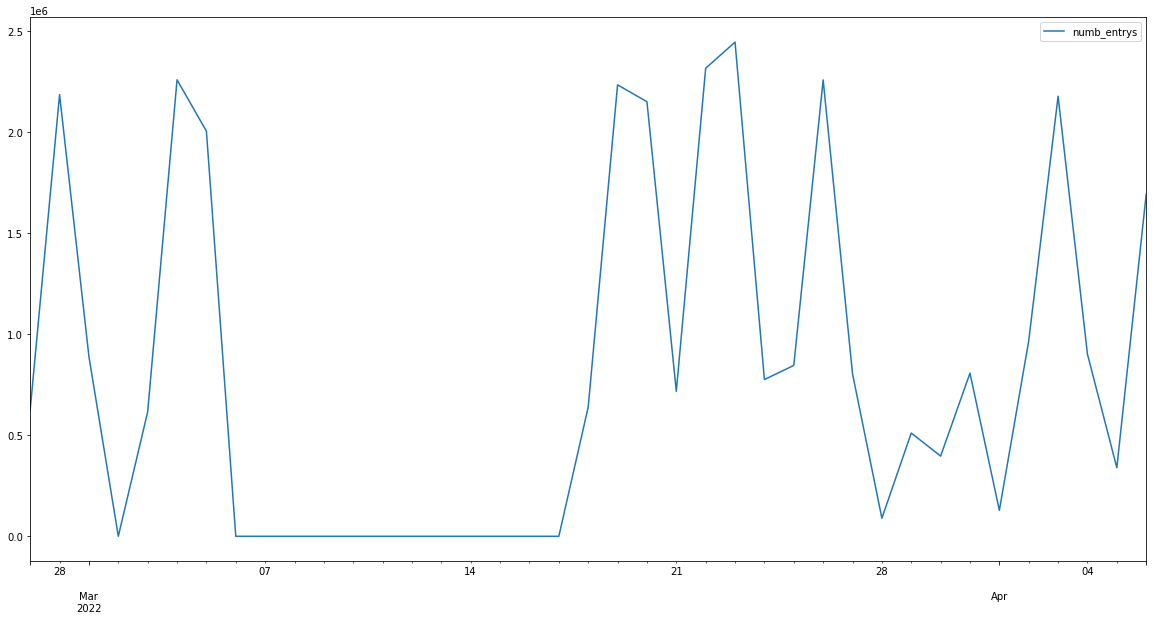

In [75]:
sqlstring = """
SELECT CAST(msgtime AS DATE) AS Datum, count(*) AS numb_entrys
FROM tbl_position
GROUP BY CAST(msgtime AS DATE)
"""
df = pd.read_sql(sqlstring,con=engine)
df.datum = pd.to_datetime(df.datum)
idx = pd.date_range(df.datum.min(), df.datum.max())
result = df.set_index('datum')
result = result.reindex(index=idx, fill_value=0)
result.plot(figsize=(20,10))

<AxesSubplot:>

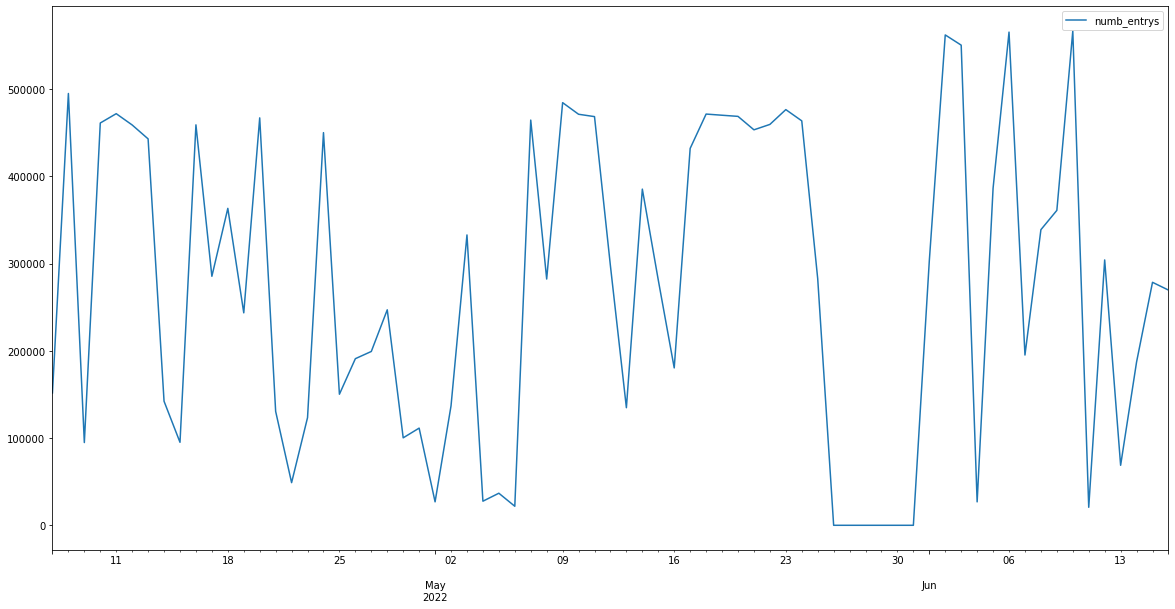

In [74]:
sqlstring = """
SELECT CAST(msgtime AS DATE) AS Datum, count(*) AS numb_entrys
FROM tbl_positionnew
GROUP BY CAST(msgtime AS DATE)
"""
df = pd.read_sql(sqlstring,con=engine)
df.datum = pd.to_datetime(df.datum)
idx = pd.date_range(df.datum.min(), df.datum.max())
result = df.set_index('datum')
result = result.reindex(index=idx, fill_value=0)
result.plot(figsize=(20,10))

## Pandas Profiling Analysis

In [4]:
sqlstring = """
SELECT *
FROM tbl_positionnew
"""
df = pd.read_sql(sqlstring,con=engine)
df.describe

<bound method NDFrame.describe of           messagetype      type       mmsi              msgtime  altitude  \
0                   1  Position  212979000  2022-04-07 16:50:00         0   
1                   1  Position  219013538  2022-04-07 16:50:00         0   
2                   1  Position  230028670  2022-04-07 16:50:00         0   
3                   1  Position  248022000  2022-04-07 16:50:00         0   
4                   1  Position  257003340  2022-04-07 16:50:00         0   
...               ...       ...        ...                  ...       ...   
19380817            3  Position  258020030  2022-06-16 10:50:00         0   
19380818            1  Position  257657600  2022-06-16 10:50:00         0   
19380819            1  Position  258913000  2022-06-16 10:50:00         0   
19380820            1  Position  257317000  2022-06-16 10:50:00         0   
19380821            3  Position  257094290  2022-06-16 10:50:00         0   

         aisclass  courseoverground  lati

In [5]:
profile = pd_profil.ProfileReport(df)

In [6]:
profile.to_file(parent_fold / "profiling_reports" / "profile_positionnew.html")

C:\Users\danie\anaconda3\lib\site-packages\scipy\stats\stats.py:4594: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


In [6]:
sqlstring = """
SELECT *
FROM tbl_staticnew
"""
df = pd.read_sql(sqlstring,con=engine)
df.describe

<bound method NDFrame.describe of           index callsign       destination  dimensiona  dimensionb  \
0             0   LG6666              None        4.00       11.00   
1             1     LHXQ          SVOLVAER        5.00       15.00   
2             2     LFIC              OSLO       20.00       10.00   
3             3   LG9701              None       10.00       26.00   
4             4   LG7886              None        3.00       12.00   
...         ...      ...               ...         ...         ...   
14263258      0    YJRJ3             SJLYR       29.00       20.00   
14263259      1     UDWX  FISHING AREA NEZ       19.00       45.00   
14263260      0     LCGH         HAUGESUND       16.00       16.00   
14263261      0   LM9935          91816751        5.00       10.00   
14263262      0     LECN      KRISTIANSAND       40.00       20.00   

          dimensionc  dimensiond  draught       eta  imonumber  messagetype  \
0               4.00        4.00      NaN     

In [ ]:
profile = pd_profil.ProfileReport(df, interactions=None)
profile.to_file(parent_fold / "profiling_reports" / "profile_staticnew.html")

C:\Users\danie\anaconda3\lib\site-packages\scipy\stats\stats.py:4594: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


## Erkenntnisse für Profile New:
* diese columns sind unnötig da nur ein wert:
  * type
  * altitude
* es gibt keine besonders hohen correlations zwischen den Werten außer latitude und longitude
* es gibt keine missing values
* einige Spalten haben eine hohe konzentration auf einen Wert
* Es gibt 6363 Duplikate in den Daten

## Erkenntnisse für Static New:
* IMO Number fehlt in fast der Hälfte der der Fälle (45,2)
* messagetype hat nur 2 Werte -> was ist der Unterschied / Bedeutung -> definieren den Type des Vessels. 5 = class A und 24 = Class B. Class A is sending with much longer range as Class B
* reportclass hat ebenfalls nur 2 Werte - extrem hohe correlation zwischen messagetype - eine spalte kann weg
* diese columns sind unnötig da nur ein Wert:
  * type
* hohe correlationen zwischen mehreren Werten:
  * shiplength <> shipwidth
  * dimensiona, dimensionb, dimensionc, dimensiond, draught, shiplength und shipwidth haben eine korrelation
* es gibt einige Datensätze mit missing data - weiter analysieren
* es gibt 140 duplicate rows